# Overview
This notebook contains a simple processing pipeline for analyzing some Covid19 data. It will first download data from John Hopkins (JH) in the form of csv files for the (1) confirmed cases, (2) deaths, and (3) recovered cases.  The first few parts of this workflow follow a great tutorial published by [B. Chen](https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6) who discusses a step-by-step procedure on using Pandas to prepare a dataset for analysis in Python. After implementing this, I developed my own plotting routines to create a few custom visualations for some countries that I have personal interest in tracking during this pandemic. These countries are US, UK, China, and Italy.

#### To run this notebook, please change the global destination folder as needed for your computer just below the list of imported libraries.

## Workflow
This is a brief discription of the functions that I developed that make up this workflow.
### download_data
This function contains the URLs for the JH data as well as path for downloading on local on your computer. This function will check for any previous data files that may have previously been downloaded and delete them before downloading the latest from JH.
### load_data
This is simple function that loads the csv files via Pandas.
### clean_data
This function does all of the reshaping, merging, grouping, sorting, etc. It ultimately produces a cleaned data set that is passed to the various plotting functions.
### barplot_deaths
This is a barplot showing deaths by country sorted in descending order for the top 20.
### lineplots_newcases
This function makes line plots showing the 7-day moving average of new cases. I created 2 versions of this plot. One normalizes for each country's population and the other does not.  I was curious to see how misleading the raw data would be if not accounting for population.
### scatterplots
This function makes a scatterplot showing the relationship between new cases and new deaths.


In [1]:
import numpy as np
import pandas as pd
import wget
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
sns.set_context('talk')
from sklearn import linear_model
from datetime import datetime, timedelta
%matplotlib inline

global destination_folder
# This is where the data will be downloaded to.
destination_folder = 'C:/Users/mjros/Documents/Python Data Sets/'

def download_data():
    
    # url of the raw csv dataset
    source_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

    urls = [
        source_path + 'time_series_covid19_confirmed_global.csv',
        source_path + 'time_series_covid19_deaths_global.csv',
        source_path + 'time_series_covid19_recovered_global.csv'
    ]

    # Before getting the data, check for old data files and delete. 
    file_confirmed = destination_folder + 'time_series_covid19_confirmed_global.csv'
    file_deaths =  destination_folder +  'time_series_covid19_deaths_global.csv'
    file_recovered =  destination_folder + 'time_series_covid19_recovered_global.csv'

    Boolean_confirmed = os.path.exists(file_confirmed)
    Boolean_deaths = os.path.exists(file_deaths)
    Boolean_recovered = os.path.exists(file_recovered)

    if Boolean_confirmed:
        print('Deleting older version of --- ',  file_confirmed)
        os.remove(file_confirmed) 

    if Boolean_deaths:
        print('Deleting older version of --- ',  file_deaths)
        os.remove(file_deaths)

    if Boolean_recovered:
        print('Deleting older version of --- ', file_recovered)
        os.remove(file_recovered)


    #[wget.download(url) for url in urls]. 
    [wget.download(url, out=destination_folder) for url in urls]
    
    
        
def load_data():
    # Read the csv files into pandas. 
    #
    # Definitions: "Confirmed" means cases that were confirmed on a given day. These cases could have started any
    # number of days before but on a given day, a case was confirmed and documented. 

    confirmed_df = pd.read_csv(destination_folder + 'time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv(destination_folder + 'time_series_covid19_deaths_global.csv')
    recovered_df = pd.read_csv(destination_folder + 'time_series_covid19_recovered_global.csv')

    # Dates start in column 4 and go to the last column.
    dates = confirmed_df.columns[4:]
    
    return confirmed_df, deaths_df, recovered_df, dates



def clean_data(confirmed_df, deaths_df, recovered_df):
    
    # This function follows the cleaning steps outlined in the reference above. The mains steps include,
    # reshaping, merging. 
    
    # Since the original data from JH is a time series that progresses in time along the rows, the first step
    # involves unpivoting (reshaping) the dataframe so that time flows down each column.
    
    # Reshape the dataframes to tall matrix form. 
    # Each country vertically at 1/1/2020
    # Each country vertically at 1/2/2020 
    #
    # Each country vertically at x/xx/xxxx
    confirmed_df_tall = confirmed_df.melt(
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=dates, 
        var_name='Date', 
        value_name='Confirmed'
    )
    deaths_df_tall = deaths_df.melt(
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=dates, 
        var_name='Date', 
        value_name='Deaths'
    )
    recovered_df_tall = recovered_df.melt(
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=dates, 
        var_name='Date', 
        value_name='Recovered'
    )

    # Canada recovered cases are removed because Canada revoveries are counted Country-wise 
    # rather than Province/State-wise
    recovered_df_tall = recovered_df_tall[recovered_df_tall['Country/Region']!='Canada']


    # Merge the deaths with the confirmed cases
    full_table = confirmed_df_tall.merge(
      right=deaths_df_tall, 
      how='left',
      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
    )


    # Merging the recovered with the confirmed-deaths merger
    full_table = full_table.merge(
      right=recovered_df_tall, 
      how='left',
      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
    )


    # Converting date to datetime
    full_table['Date'] = pd.to_datetime(full_table['Date'])

    # Survey how many missing values in each column
    full_table.isna().sum()

    # Fill the NaN with zeros
    full_table['Recovered'] = full_table['Recovered'].fillna(0)


    # This section deals with the cruise ships and essentially eliminates them
    ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')
    full_ship = full_table[ship_rows]
    full_table = full_table[~(ship_rows)]


    # Active Case = confirmed - deaths - recovered
    # The logic here is "Active" cases derives from "Confirmed" cases.  Then some portion of the "Confirmed"
    # end up Dead and another portion end up Recovered. So if we decrease Confirmed by Deaths and Recovered 
    # we are left with Active living cases of virus.
    full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

    # Aggregate the full table by summing the Confirmed, Deaths, Recovered over Date for each Country/Region
    # Here the summation will total up values for all the provinces or states a country may have and boil that 
    # down to a sing number to represent the country. For example, China has over 30 provinces in the raw data
    # for each time stamp. The groupby will total these up and result in one grand total for China for that 
    # particular time stamp and then will do this for all the time stamps.
    full_grouped = full_table.groupby(['Date', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()


    # Here is how the new cases, new deaths, new recovered are found. They will be contained in a separate dataframe and
    # later on merged into the full_grouped.  First, start with data frame that was just found
    # for the full_grouped by Date, Country/Region.  Then this data is grouped by Country/Region, Date (notice it's
    # reversed order from the full_table groupby in the previous section). The sum() does the same aggregations as before.
    # 
    # For every day that data is avaialable, the "New cases" is defined as New cases =  Confirmed(i) - Confirmed(i-1)
    # This is a perfect job for the diff() function which is why it is used here. This will introduce some boundary
    # errors when there is no i-1 date available or if the diff() is operating on Country transistions.
    daywise_df = full_grouped.groupby(['Country/Region', 'Date', ])[['Confirmed', 'Deaths', 'Recovered']]
    daywise_df = daywise_df.sum().diff().reset_index()

    # This mask tracks the Country discontinuities across neighboring rows and forces in NaN values
    mask = daywise_df['Country/Region'] != daywise_df['Country/Region'].shift(1)
    daywise_df.loc[mask, 'Confirmed'] = np.nan
    daywise_df.loc[mask, 'Deaths'] = np.nan
    daywise_df.loc[mask, 'Recovered'] = np.nan

    # Renaming columns of this little daywise dataframe
    daywise_df.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']

    # Merging the daywise dataframe into the full grouped dataframe
    full_grouped = pd.merge(full_grouped, daywise_df, on=['Country/Region', 'Date'])

    # Clean up any NaN values by filling na with 0. 
    full_grouped = full_grouped.fillna(0)

    # Cast the new columns as integers 
    cols = ['New cases', 'New deaths', 'New recovered']
    full_grouped[cols] = full_grouped[cols].astype('int')

    # Clean up any negative values by seting negative values to 0
    full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

    # Save out the cleaned data file to csv file
    full_grouped.to_csv(destination_folder + 'COVID-19-time-series-clean-complete.csv')

    return full_grouped


def barplot_deaths(full_grouped):
    
    # Here I am making a barplot to show the top 20 countries with the worst death totals
    
    fig= plt.figure()
    axes= fig.add_axes([0,0,3,1.5])
    bar_width = 0.4

    # Shorten the United Kingdom and South Africa label 
    df_top20.at[184,'Country/Region']='UK'
    df_top20.at[160,'Country/Region']='S. Africa'

    bars = sns.barplot(x='Country/Region', y='Deaths', data = df_top20)
    # bars = plt.bar(df_top20['Country/Region'], df_top20['Deaths'], align='center', linewidth=0, color='blue',alpha=0.2)

    for pos in ['right', 'top', 'bottom', 'left']:
        plt.gca().spines[pos].set_visible(False)

    z = plt.gca().xaxis
    for item in z.get_ticklabels():
        item.set_rotation(45)

    plt.title('Deaths by Country', alpha=0.8, fontsize=42)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    bars.set(xlabel=None)
    bars.set(ylabel=None)
    plt.show
    
def generate_features(full_grouped):
    
    # This function parses out the features that I would like to generate visuals for and includes (1) a dataframe
    # containing the death totals for the top 20 countries, (2) dataframes for 4 countries of interest to me (uk, italy,
    # usa, china). For each country I computed the 7-day moving average of new cases and new deaths and stored these 
    # quantities as new columns in their respective dataframes
    
    # Top 20 countries leading in deaths
    df_deaths = full_grouped.groupby(['Country/Region'])['Deaths'].max().reset_index()
    df_top20 = df_deaths.sort_values(by='Deaths',ascending=False).iloc[:20]
    
    
    # Create a copy of countries of interest
    uk = full_grouped.loc[full_grouped['Country/Region'] == 'United Kingdom'].copy()
    italy = full_grouped.loc[full_grouped['Country/Region'] == 'Italy'].copy()
    usa = full_grouped.loc[full_grouped['Country/Region'] == 'US'].copy()
    china = full_grouped.loc[full_grouped['Country/Region'] == 'China'].copy()
    

    # Compute moving average of new cases for a few countries and add this data to their respective dataframes
    uk['Moving average'] = uk['New cases'].rolling(window=7,center=True).mean()
    italy['Moving average'] = italy['New cases'].rolling(window=7,center=True).mean()
    usa['Moving average'] = usa['New cases'].rolling(window=7,center=True).mean()
    china['Moving average'] = china['New cases'].rolling(window=7,center=True).mean()

    # Here let's compute moving average for deaths for a few countries and populate the dataframes
    uk['Moving average deaths'] = uk['New deaths'].rolling(window=7,center=True).mean()
    italy['Moving average deaths'] = italy['New deaths'].rolling(window=7,center=True).mean()
    usa['Moving average deaths'] = usa['New deaths'].rolling(window=7,center=True).mean()
    china['Moving average deaths'] = china['New deaths'].rolling(window=7,center=True).mean()
    
    # Populations of a few countries take from a google search.
    pop_USA = 326000000
    pop_China = 1444216107
    pop_Italy = 60400000
    pop_UK =    66400000
    pop_thoeretical = 100000
    
    
    # Create new columns to hold the moving averages of new cases accounting for population
    uk['Cases per 100K averaged'] = uk.apply(lambda x:x['Moving average']*(pop_thoeretical/pop_UK), axis=1)
    italy['Cases per 100K averaged'] = italy.apply(lambda x:x['Moving average']*(pop_thoeretical/pop_Italy), axis=1)
    usa['Cases per 100K averaged'] = usa.apply(lambda x:x['Moving average']*(pop_thoeretical/pop_USA), axis=1)
    china['Cases per 100K averaged'] = china.apply(lambda x:x['Moving average']*(pop_thoeretical/pop_China), axis=1)
    
    # Create new columns to hold the moving averages of new deaths accounting for population
    uk['Deaths per 100K averaged'] = uk.apply(lambda x:x['Moving average deaths']*(pop_thoeretical/pop_UK), axis=1)
    italy['Deaths per 100K averaged'] = italy.apply(lambda x:x['Moving average deaths']*(pop_thoeretical/pop_Italy), axis=1)
    usa['Deaths per 100K averaged'] = usa.apply(lambda x:x['Moving average deaths']*(pop_thoeretical/pop_USA), axis=1)
    china['Deaths per 100K averaged'] = china.apply(lambda x:x['Moving average deaths']*(pop_thoeretical/pop_China), axis=1)
    
    # Create new columns to hold the raw data of new cases accounting for population
    uk['Cases per 100K raw'] = uk.apply(lambda x:x['New cases']*(pop_thoeretical/pop_UK), axis=1)
    italy['Cases per 100K raw'] = italy.apply(lambda x:x['New cases']*(pop_thoeretical/pop_Italy), axis=1)
    usa['Cases per 100K raw'] = usa.apply(lambda x:x['New cases']*(pop_thoeretical/pop_USA), axis=1)
    china['Cases per 100K raw'] = china.apply(lambda x:x['New cases']*(pop_thoeretical/pop_China), axis=1)
    
    # Create new columns to hold the raw data of new deaths accounting for population
    uk['Deaths per 100K raw'] = uk.apply(lambda x:x['New deaths']*(pop_thoeretical/pop_UK), axis=1)
    italy['Deaths per 100K raw'] = italy.apply(lambda x:x['New deaths']*(pop_thoeretical/pop_Italy), axis=1)
    usa['Deaths per 100K raw'] = usa.apply(lambda x:x['New deaths']*(pop_thoeretical/pop_USA), axis=1)
    china['Deaths per 100K raw'] = china.apply(lambda x:x['New deaths']*(pop_thoeretical/pop_China), axis=1)
    
    return uk, italy, usa, china, df_top20
    
    
def lineplots_newcases(uk, italy, usa, china):
    
    title_font = 28
       

    # Plot countries daily cases per 100K
    fig= plt.figure()
    axes= fig.add_axes([0,0,1.5,1.5])
    sns.lineplot(x='Date',y='Cases per 100K averaged',data=usa, label='USA',color='cyan', alpha=0.7)
    sns.lineplot(x='Date',y='Cases per 100K averaged',data=uk, label='UK',color='blue', alpha=0.7)
    sns.lineplot(x='Date',y='Cases per 100K averaged',data=italy, label='Italy',color='orange', alpha=0.7)
    sns.lineplot(x='Date',y='Cases per 100K averaged',data=china, label='China',color='red', alpha=0.7)

    # Rotation
    z = plt.gca().xaxis
    for item in z.get_ticklabels():
        item.set_rotation(45)
        
    # remove outer box
    for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)

    plt.setp(axes.spines.values(), color='dimgrey')
    
#     axes.set_yscale('log')

    axes.set_title('7-Day Moving Average New Daily Cases per 100K', fontdict={'fontsize':title_font},color='black', alpha=0.7)
    axes.set(xlabel=None)
    axes.set(ylabel=None)
    axes.tick_params(axis='x', colors='dimgrey')
    axes.tick_params(axis='y', colors='dimgrey')
    legend = plt.legend()
    legend.get_frame().set_facecolor('none')
    
    plt.legend(frameon=False)
    plt.show()
    
   
    # Straight up plot without normalizing by population
    fig= plt.figure()
    axes= fig.add_axes([0,0,1.5,1.5])
    sns.lineplot(x='Date',y='Moving average',data=usa, label='USA',color='cyan', alpha=0.7)
    sns.lineplot(x='Date',y='Moving average',data=uk, label='UK',color='blue', alpha=0.7)
    sns.lineplot(x='Date',y='Moving average',data=italy, label='Italy',color='orange', alpha=0.7)
    sns.lineplot(x='Date',y='Moving average',data=china, label='China',color='red', alpha=0.7)

    
    z = plt.gca().xaxis
    for item in z.get_ticklabels():
        item.set_rotation(45)
        
    # remove outer box
    for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)

    plt.setp(axes.spines.values(), color='dimgrey')
    
#     axes.set_yscale('log')

    axes.set_title('7-Day Moving Average New Daily Cases', fontdict={'fontsize':title_font},color='black', alpha=0.7)
    axes.set(xlabel=None)
    axes.set(ylabel=None)
    axes.tick_params(axis='x', colors='dimgrey')
    axes.tick_params(axis='y', colors='dimgrey')
    legend = plt.legend()
    legend.get_frame().set_facecolor('none')
    
    plt.legend(frameon=False)
    plt.show()
    
def scatterplots(uk, italy, usa, china):
    
    # Scatterplot New cases per 100K vs New deaths per 100K
    fig= plt.figure()
    axes= fig.add_axes([0,0,1.5,1.5])
    sns.scatterplot(x='Cases per 100K raw',y='Deaths per 100K raw',data=usa, label='USA',color='cyan', alpha=0.3)
    sns.scatterplot(x='Cases per 100K raw',y='Deaths per 100K raw',data=uk, label='UK',color='blue', alpha=0.3)
    sns.scatterplot(x='Cases per 100K raw',y='Deaths per 100K raw',data=italy, label='Italy',color='orange', alpha=0.3)
    sns.scatterplot(x='Cases per 100K raw',y='Deaths per 100K raw',data=china, label='China', color='red',  alpha=0.6)
#     plt.scatter(usa['Cases per 100K raw'],usa['Deaths per 100K raw'], label='USA',color='cyan', alpha=0.3)
#     plt.scatter(uk['Cases per 100K raw'],uk['Deaths per 100K raw'], label='UK',color='blue', alpha=0.3)
#     plt.scatter(italy['Cases per 100K raw'],italy['Deaths per 100K raw'], label='Italy',color='orange', alpha=0.3)
#     plt.scatter(china['Cases per 100K raw'],china['Deaths per 100K raw'], s=10, label='China',color='red', alpha=0.3)
    
    # remove outer box
    for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)

    plt.setp(axes.spines.values(), color='dimgrey')
    axes.tick_params(axis='x', colors='dimgrey')
    axes.tick_params(axis='y', colors='dimgrey')
    axes.set(xlabel='New Cases per 100K')
    axes.set(ylabel='New Deaths per 100K')
    axes.xaxis.label.set_color('dimgrey')
    axes.yaxis.label.set_color('dimgrey')

    axes.set_title('Scatterplot New Cases vs. New Deaths', fontdict={'fontsize':28},color='black', alpha=0.7)

    plt.legend(frameon=False)
    plt.show()


In [2]:
# Download the latest Covid datafiles. Make sure paths are correct in function above.
download_data()

# Load data
confirmed_df, deaths_df, recovered_df, dates = load_data()

# Clean data
full_grouped = clean_data(confirmed_df, deaths_df, recovered_df)



Deleting older version of ---  C:/Users/mjros/Documents/Python Data Sets/time_series_covid19_confirmed_global.csv
Deleting older version of ---  C:/Users/mjros/Documents/Python Data Sets/time_series_covid19_deaths_global.csv
Deleting older version of ---  C:/Users/mjros/Documents/Python Data Sets/time_series_covid19_recovered_global.csv


In [3]:
# Prepare features for the plots
uk, italy, usa, china, df_top20 = generate_features(full_grouped)

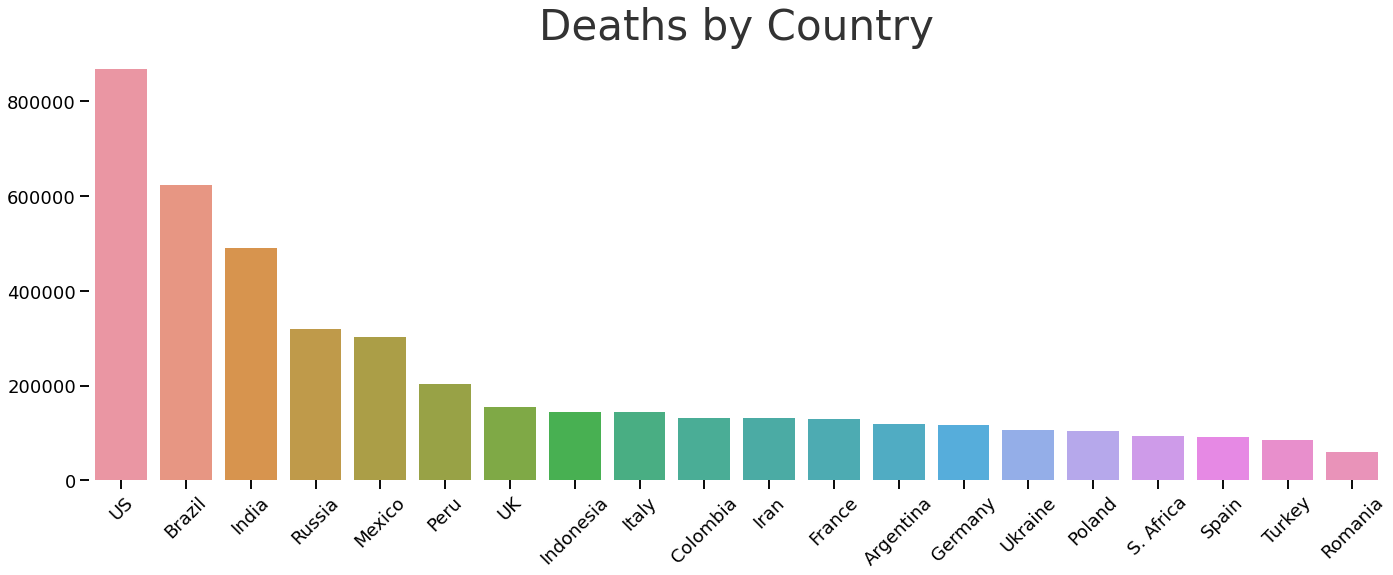

In [4]:
# Top 20 deaths barplot
barplot_deaths(df_top20)

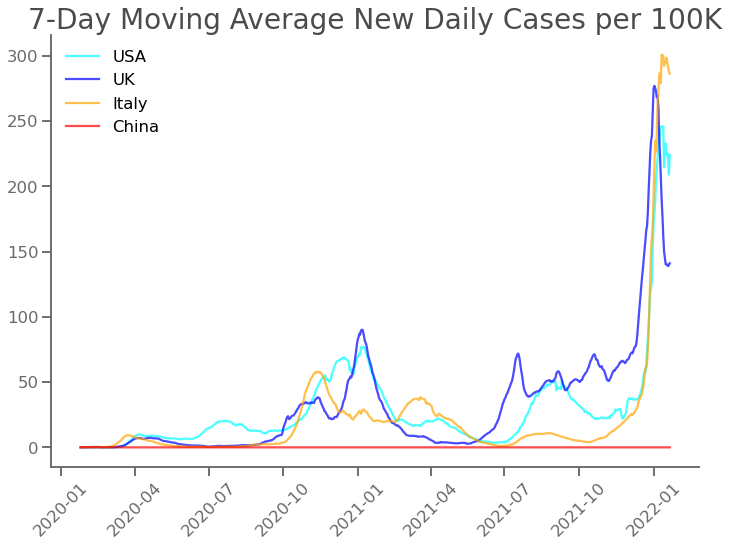

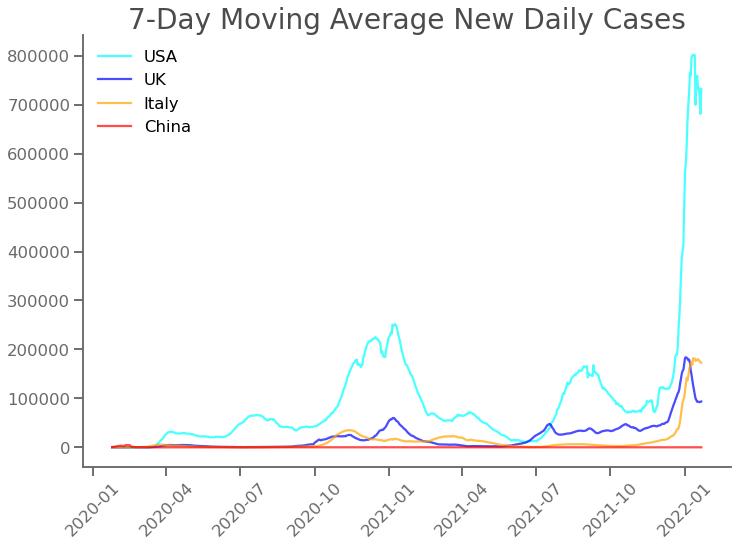

In [5]:
# Lineplots
lineplots_newcases(uk, italy, usa, china)

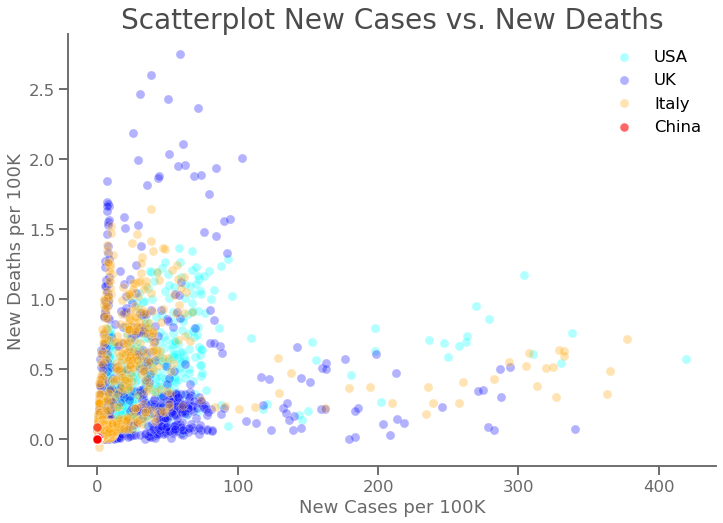

In [6]:
# Scatterplots
scatterplots(uk, italy, usa, china)